In [ ]:


from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
pip install konlpy

In [31]:
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 데이터 불러오기
가리산자연휴양림 = pd.read_excel("/content/gdrive/MyDrive/홍천군/가리산자연휴양림크롤링.xlsx")

# 텍스트 파일로 저장된 불용어 목록 불러오기
with open('/content/gdrive/MyDrive/홍천군/stopwords-ko.txt','r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# NaN 값을 빈 문자열로 대체
가리산자연휴양림['본문 내용'] = 가리산자연휴양림['본문 내용'].fillna('')

# 불용어 제거 (float 방지 처리 추가)
가리산자연휴양림['본문 내용'] = 가리산자연휴양림['본문 내용'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords]) if isinstance(x, str) else x)

# 특수 문자 및 불필요한 기호 제거
가리산자연휴양림["본문 내용"] = 가리산자연휴양림["본문 내용"].apply(lambda x: re.sub(r'[^가-힣\s]', '', str(x)) if isinstance(x, str) else x)

# 줄바꿈 문자 제거
가리산자연휴양림['본문 내용'] = 가리산자연휴양림['본문 내용'].apply(lambda x: re.sub(r'[\n]', ' ', str(x)) if isinstance(x, str) else x)

# 형태소 분석
okt = Okt()
가리산자연휴양림['본문 내용'] = 가리산자연휴양림['본문 내용'].apply(lambda x: ' '.join(okt.nouns(x)) if isinstance(x, str) else x)

# 추가 불용어 목록 정의
custom_stopwords = ['홍천군','실내','방문','강원도','연구','자연','전시관','진짜', '홍천', '강원',
                    '내촌면', '시작', '정도','특별자치도','북방면','가리산','사진','바로가기','정상',
                    '하산','위치','당일','가능','내년','이건','와중','자연휴양림','도착','정말','사람',
                    '화장실','주차장','이유','모델링','그냥','여행','두촌면','이용','방향','명산','공사']  # 필요시 추가 단어
stopwords += custom_stopwords

# CountVectorizer로 문서-단어 행렬 생성 (업데이트된 stopwords 적용)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords)
X = vectorizer.fit_transform(가리산자연휴양림['본문 내용'])

# LDA 모델 설정 (토픽 개수는 5로 설정)
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# 토픽별 주요 단어 확인 함수
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# 각 토픽에서 상위 10개의 단어 출력
display_topics(lda, vectorizer.get_feature_names_out(), 10)

# 문서-주제 분포 추출
doc_topic_dist = lda.transform(X)

# 문서별로 각 토픽에 대한 확률 확인
가리산자연휴양림['주요 토픽'] = doc_topic_dist.argmax(axis=1)
print(가리산자연휴양림[['본문 내용', '주요 토픽']].head())

# 데이터프레임을 CSV로 저장
# 금학산.to_csv('/content/gdrive/MyDrive/홍천군/금학산_주요토픽_분석.csv', index=False)

# 각 단어의 빈도수 계산
word_counts = X.toarray().sum(axis=0)

# 단어와 그 빈도수를 매핑
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))

# 상위 20개의 빈도수가 높은 단어 출력
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
for word, freq in sorted_word_freq[:40]:
    print(f"{word}: {freq}")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn(


Topic 0:
용소 계곡 폭포 휴양림 숙소 플라잉 고기 아침 파크 포츠
Topic 1:
우렁이 쌈밥 최대 산막 예약 맛집 식당 근처 휴양림 식사
Topic 2:
등산 계곡 고개 등산로 버스 휴양림 무쇠 말재 나무 계단
Topic 3:
코스 무쇠 말재 고개 계단 산행 등산 휴양림 레이더 출발
Topic 4:
산막 소형 데크 예약 계곡 야영장 계단 텐트 사용 캠핑
Topic 5:
여름 축제 파크 맥주 포츠 코스 힐링 계곡 가장 기도
Topic 6:
계곡 입장료 데크 계단 크게 휴양림 야영장 소리 산막 체크
Topic 7:
계곡 산행 여유 휴양림 코스 입구 서울 등산 산막 샤워
Topic 8:
산막 시설 캠핑 코스 소형 산행 휴양림 가장 계곡 친구
Topic 9:
코스 등산 주차 최단 데크 등산로 레이더 무쇠 말재 강우
                                               본문 내용  주요 토픽
0  블랙 야크 명산 인증 나름 중인 효 대장 전 플로 깅 크루 산 사병 홍천 가리산 가...      9
1  임신 주 홍천 국내 여행 년 새해 저 임신 주 박일 여행 캠핑 장작 마지막 마음 가...      1
2  철원 두루 웰 숲속 문화 촌 다음 목적지 홍천 가리산 휴양림 도착 오후 시가 숙소 ...      0
3  가리산 자연휴양림 공사 기간 주차장 입장료 편의 시설 박 일 아들 인제 속초 바퀴 ...      6
4  당일치기 강원도 홍천 여행 오늘 월 일 홍천 맥주 축제 홍천 도착 점심 간 곳 가리...      1
코스: 151
계곡: 139
휴양림: 103
등산: 100
산막: 99
계단: 87
데크: 79
고개: 70
무쇠: 70
말재: 65
산행: 65
주차: 63
예약: 61
등산로: 53
소형: 49
시설: 49
출발: 44
생각: 43
여름: 42
용소: 40
나무: 39
레이더: 39
캠핑: 38
강우: 37
관측: 37
버스: 37
아침: 36
입장료: 36
다시: 35
바람: 34
아래: 32
오늘: 32
폭포

In [32]:
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 혼잡도(Perplexity) 계산
print("Perplexity: ", lda.perplexity(X_test))

# 토픽 특이성(Topic Distinctiveness) 계산
def calculate_topic_distinctiveness(lda_model):
    topic_words = [set([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]) for topic in lda_model.components_]
    distinctiveness = []
    for i, topic in enumerate(topic_words):
        other_topics = set.union(*[t for j, t in enumerate(topic_words) if j != i])
        dist = 1 - len(topic.intersection(other_topics)) / len(topic)
        distinctiveness.append(dist)
    return distinctiveness

topic_distinctiveness = calculate_topic_distinctiveness(lda)
for topic_idx, dist in enumerate(topic_distinctiveness):
    print(f"Topic {topic_idx} Distinctiveness: {dist}")

# 각 토픽의 top 단어들 출력
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

Perplexity:  33936.02784919855
Topic 0 Distinctiveness: 0.6
Topic 1 Distinctiveness: 0.7
Topic 2 Distinctiveness: 0.19999999999999996
Topic 3 Distinctiveness: 0.09999999999999998
Topic 4 Distinctiveness: 0.19999999999999996
Topic 5 Distinctiveness: 0.5
Topic 6 Distinctiveness: 0.4
Topic 7 Distinctiveness: 0.4
Topic 8 Distinctiveness: 0.19999999999999996
Topic 9 Distinctiveness: 0.30000000000000004
Topic 0: 용소, 계곡, 폭포, 휴양림, 숙소, 플라잉, 고기, 아침, 파크, 포츠
Topic 1: 우렁이, 쌈밥, 최대, 산막, 예약, 맛집, 식당, 근처, 휴양림, 식사
Topic 2: 등산, 계곡, 고개, 등산로, 버스, 휴양림, 무쇠, 말재, 나무, 계단
Topic 3: 코스, 무쇠, 말재, 고개, 계단, 산행, 등산, 휴양림, 레이더, 출발
Topic 4: 산막, 소형, 데크, 예약, 계곡, 야영장, 계단, 텐트, 사용, 캠핑
Topic 5: 여름, 축제, 파크, 맥주, 포츠, 코스, 힐링, 계곡, 가장, 기도
Topic 6: 계곡, 입장료, 데크, 계단, 크게, 휴양림, 야영장, 소리, 산막, 체크
Topic 7: 계곡, 산행, 여유, 휴양림, 코스, 입구, 서울, 등산, 산막, 샤워
Topic 8: 산막, 시설, 캠핑, 코스, 소형, 산행, 휴양림, 가장, 계곡, 친구
Topic 9: 코스, 등산, 주차, 최단, 데크, 등산로, 레이더, 무쇠, 말재, 강우


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

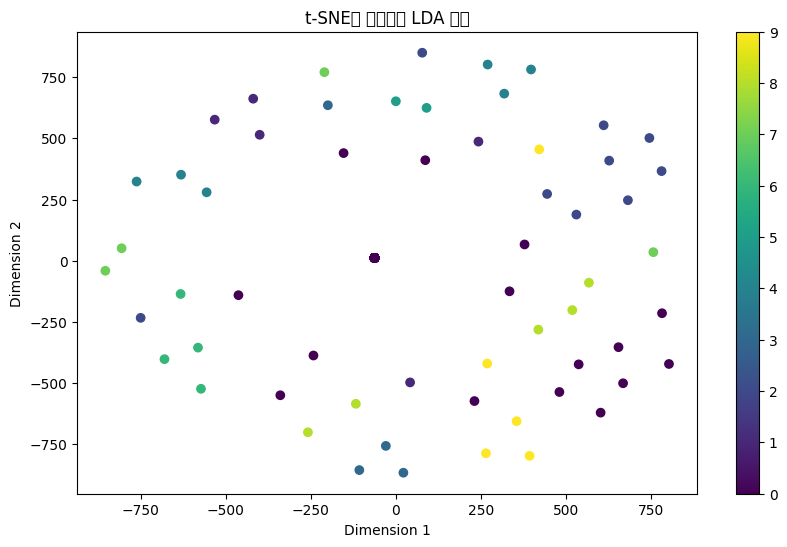

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

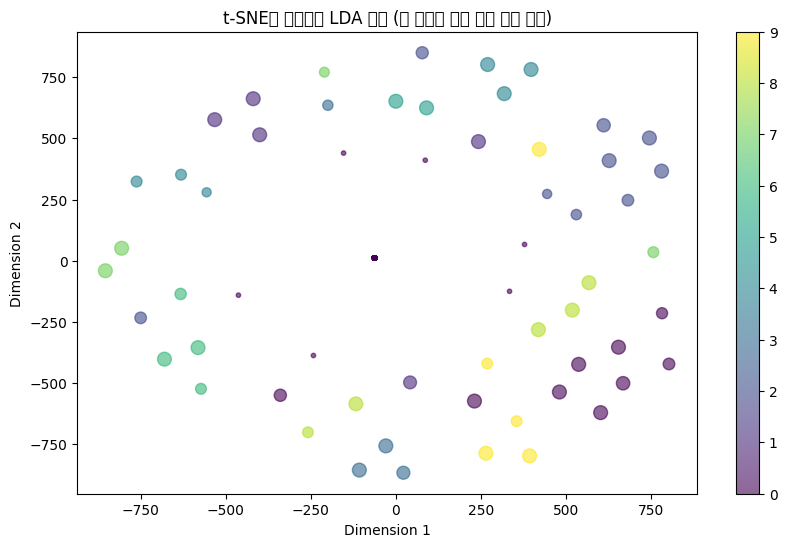

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 사용하여 차원 축소 (2차원으로 축소)
tsne_model = TSNE(n_components=2, random_state=42)
tsne_lda = tsne_model.fit_transform(doc_topic_dist)

# 차원 축소된 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=doc_topic_dist.argmax(axis=1))  # 각 문서의 가장 중요한 토픽으로 색상 구분
plt.colorbar()
plt.title('t-SNE로 시각화한 LDA 결과')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()



import matplotlib.pyplot as plt
import numpy as np

# t-SNE로 차원 축소된 값인 tsne_lda 사용
# 각 문서에서 가장 큰 토픽 확률을 점의 크기로 사용
doc_sizes = np.max(doc_topic_dist, axis=1) * 100  # 확률에 비례하여 점 크기 설정

# 시각화 (원의 크기는 확률에 비례)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], s=doc_sizes, c=doc_topic_dist.argmax(axis=1), cmap="viridis", alpha=0.6)

# 컬러바 추가
plt.colorbar(scatter)
plt.title('t-SNE로 시각화한 LDA 결과 (점 크기는 주요 토픽 확률 비례)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()



In [ ]:
# 군집을 확인해보면 초록색, 파란색이 군집이 잘 이뤄진 것을 확인할 수 있다.
# 보라색도 군집이 이뤄졌지만, 분포가 큰 것을 확인할 수 있다.
# 초록색 계열 군집은 그 수가 적은편인 것으로 보아 분석에서 제외하는 것을 고려할 수 있다.

#서로 다른 색상이 일정한 거리를 유지하고 있을 경우, 이는 주제 간에 명확한 차별성이 있다는 것을 나타낸더.
# 반면 색상이 섞여 있다면 이는 다양한 주제가 혼합된 문서들이 존재한다는 것을 의미한다.
# 큰 점들은 그 문서에서 하나의 주제가 매우 중요한 역할을 한다는 것을 의미한다.


In [ ]:
# display_topics(lda, vectorizer.get_feature_names_out(), 100)


# ###


In [ ]:
# 토픽별 데이터프레임 저장

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

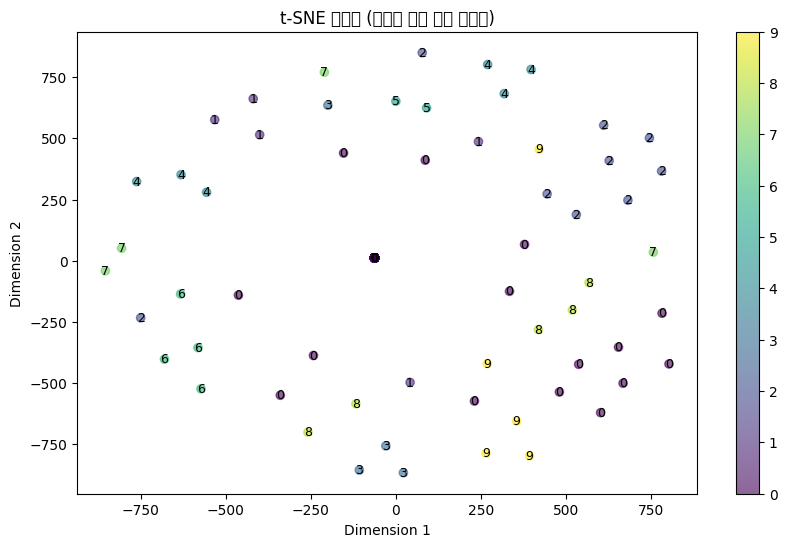

In [35]:
import pandas as pd

# 각 토픽별 상위 키워드를 저장하는 함수
def get_topics_dataframe(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_keywords = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append({"토픽 번호": f"Topic {topic_idx}", "주요 키워드": ", ".join(topic_keywords)})
    return pd.DataFrame(topics)

# 각 토픽별 상위 50개의 단어를 저장한 데이터프레임 생성
topics_df = get_topics_dataframe(lda, vectorizer.get_feature_names_out(), 50)

# 데이터프레임 확인
topics_df

# CSV 파일로 저장
topics_df.to_csv('가리산자연휴양림_final.csv', index=False)



### 데이터 프레임 군집 라벨링
import pandas as pd

# 문서-주제 분포 계산 (lda.transform()을 통해 얻은 결과)
doc_topic_dist = lda.transform(X)

# 각 문서에서 가장 높은 확률을 가진 주제를 할당
dominant_topic = doc_topic_dist.argmax(axis=1)

# 기존 데이터프레임에 토픽 정보 추가
가리산자연휴양림['주요 토픽'] = dominant_topic

# 토픽 번호와 문서 간 매칭 데이터프레임 확인
가리산자연휴양림[['본문 내용', '주요 토픽']].head()


import matplotlib.pyplot as plt
import numpy as np

# t-SNE로 차원 축소된 값 사용
# 각 문서에서 가장 높은 토픽 확률을 기반으로 색상 지정
plt.figure(figsize=(10, 6))

# 각 문서의 주요 토픽으로 색상을 구분하여 시각화
scatter = plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=dominant_topic, cmap="viridis", alpha=0.6)

# 각 점에 문서의 주요 토픽 라벨 추가
for i, label in enumerate(dominant_topic):
    plt.text(tsne_lda[i, 0], tsne_lda[i, 1], str(label), fontsize=9, ha='center', va='center')

plt.colorbar(scatter)
plt.title('t-SNE 시각화 (문서별 주요 토픽 라벨링)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()




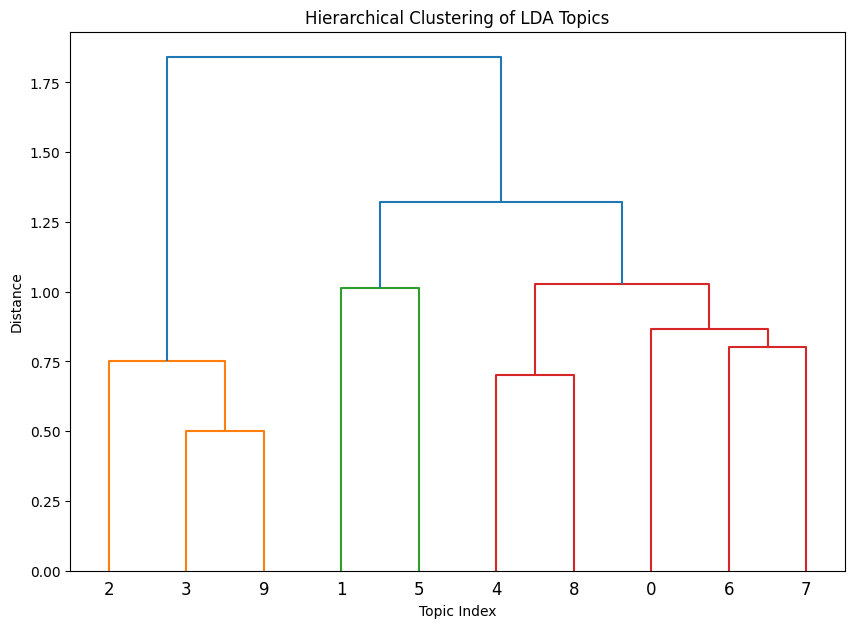

Cluster 1: Topics [2, 3, 9]
Cluster 2: Topics [1]
Cluster 3: Topics [5]
Cluster 4: Topics [4, 8]
Cluster 5: Topics [0, 6, 7]


In [36]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# LDA 모델의 토픽-단어 분포를 가져옵니다
topic_word_dist = lda.components_

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(topic_word_dist)
distance_matrix = 1 - similarity_matrix

# 계층적 군집화 수행
linkage_matrix = linkage(distance_matrix, method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering of LDA Topics')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

# 군집 결과 얻기 (예: 4개의 군집으로 나누기)
from scipy.cluster.hierarchy import fcluster
num_clusters = 5
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# 결과 출력
for i in range(1, num_clusters + 1):
    print(f"Cluster {i}: Topics {[j for j, c in enumerate(clusters) if c == i]}")